In [1]:
# QGA_multiSolution version
import qiskit
qiskit.__version__

'0.16.1'

$$
\delta \theta 1 = 0.08\pi \\
\delta \theta 2 = 0.001\pi 
$$

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import qrng
from math import pi
import random
import pandas as pd
import seaborn as sns

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_textbook.tools import array_to_latex

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
#Initialize HyperParameter
MaxNsol = 300 #define MaxNsol
MaxNvar = 150 #define MaxNvar

# Nrun = 10     #define Nrun
Ngen = 200   #define Ngen  
Nsol = 5     #define Nsol
Nvar = 10     #define Nvar
Nbit = 10      #define the variable bits
Qbest_sol = Nsol + 1 # solution Number include Qbest_sol 
Qbest_idx = Nsol # Index of Qbest_sol 
theta_1 = 0.08 *pi
theta_2 = 0.001 *pi

Cg = 0.7 #define Cg
Cp = 0.9 #define Cp  
# Cw = 0.9 #define Cw

apitoken ='e26cab383f69b81aaf36106b0620f3e994afd5ef57bb861bc714b41a91dabb3c08dcc5f5f45fa395a490d1bbf0490a8b1e7caeeaa560546833ca8149d4375ef3'

In [4]:
# Create QuantumCircuit List = sol_list
# return a qc_list represent the solution value [x1, x2, x3, ...]
def Qsol_init():
    qc_list = []

    for var in range(Nvar):
        qc = QuantumCircuit(Nbit, Nbit) # Circuit with Nbit qubits and Nbit classical bits
        qr = QuantumRegister(Nbit, 'q')
        cr = ClassicalRegister(Nbit, 'c')
        qc = QuantumCircuit(qr, cr)
        qc.h(qr[0:Nbit])
        qc_list.append(qc)
    return qc_list # return a solution 有Nvar

In [5]:
# Initialize one generation with Nsol
def God_init():
    '''
    Initialize one generation with Nsol.
    Each solution is a chromosome with Qubit.
    '''
    God_list = []
    for sol in range(Nsol):
        God_list.append(Qsol_init())
    return God_list
# God_list = God_init()

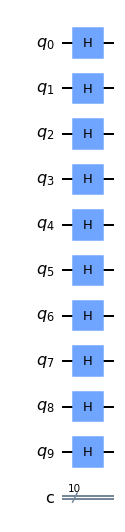

In [6]:
# Qgen_list[sol_i][var_i]
God_list = God_init()
God_list[0][0].draw('mpl')

In [7]:
# 經過以上的看看態向量！
# array_to_latex(out_state, pretext="\\text{Statevector} = ")

In [8]:
def sol_measure(Qsol_list):
    '''
    This function input a chromosome with Qubit and return its classical bit measurement solution list.
    '''
    Csol_list = []
    Qstate_list = []
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend

    for qc in Qsol_list:
        qc_copy = qc
        for bit in range(Nbit):
            qc_copy.measure(bit, bit)
        result = execute(qc_copy, simulator).result() # defaul shot number
        result_dict = result.to_dict()
        Qstate_list.append(result_dict['results'][0]['data']['counts'])
    for var in Qstate_list:
        Keymax = max(var, key=var.get) 
        Csol_list.append(int(Keymax, 16))
    return Csol_list

# init_sol_list = sol_measure(God_list[0])
# init_sol_list

In [9]:
def var_measure(qc):
    '''
    var_measure function：Measure one variable with Nbit to classical bits.
    '''
    # Use simulator to measure one solution
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend
    qc_copy = qc.copy()
    for bit in range(Nbit):
        qc_copy.measure(bit, bit)
    result = execute(qc_copy, simulator).result() # defaul shot number
    result_dict = result.to_dict()
    # print(result_dict)
    var_dict = result_dict['results'][0]['data']['counts']
    Keymax = max(var_dict, key=var_dict.get) 
    return int(Keymax, 16)

$$
Min \ Z = x_1^2 + x_2^2 + x_3^2 + ... + x_n^2
$$

In [10]:
def FIT_cal(XX):
    '''
    This function define the OBJ function and return the fitness value.
    In this example we use the square sum of each variable.
    '''
    SUM = 0
    for var in range(Nvar):
        SUM += XX[var] * XX[var]
    return SUM

In [11]:
def best_dict_init():
    '''
    Use best_dict to storage the gbest_fitness, gbest_list, chromosome_fitness, chromosome_list
    '''
    best_dict = {
        "gbest_fitness": 0,
        "gbest_sol": [0 for i in range(Nvar)],
        "chromosome_fitness":[0 for i in range(Nsol)],
        "chromosome_list":[[0 for i in range(Nvar)] for j in range(Nsol)]
    }
    return best_dict
best_dict = best_dict_init()

### Rotation around Y-axis
#### Main update operation of Quantum Genetic Algorithm

$$
R_y(\theta) =
\begin{pmatrix}
\cos(\theta/2) & - \sin(\theta/2)\\
\sin(\theta/2) & \cos(\theta/2).
\end{pmatrix} =u3(\theta,0,0)
$$

In [12]:
def int_to_bin(var):
    '''
    Def a function to convert int to binary_string.
    '''
    return format(var, f'0{Nbit}b')
# int_to_bin(12)

In [13]:
def get_Qrnd():
    '''
    Function to get random number from a Qubit in Quantum Computer.
    '''
    # IBMQ.save_account(apitoken)
    # provider = IBMQ.load_account()
    # qrng.set_provider_as_IBMQ(apitoken) #the IBMQ API token from your dashboard
    qrng.set_backend() #connect to the k qubit by quantum computer
    rnd = qrng.get_random_float(0,1) #generate a random N bit float between 0 to 1
    return rnd
# rnd = get_Qrnd()
# rnd

In [14]:
def sol_update(sol, last_gen_fitness):
    '''
    Get a solution with Nvar from Qsol_list.
    '''
    Random_Qlist = Qsol_init()
    print('sum: ', sum(last_gen_fitness))
    prob_list = [(last_gen_fitness[i] / sum(last_gen_fitness)) for i in range(Nsol)]
    print(f'prob_list: {prob_list}')

    sol_list = []
    chose_list = [idx for idx in range(Nsol)]
    rnd = get_Qrnd()
    parent = random.choices(chose_list, weights=prob_list, k = 1)[0]
    print(parent)

    for var in range(Nvar):
        variable = (var_measure(God_list[parent][var]))
        sol_list.append(variable)
    return sol_list


In [15]:
def sol_init():
    '''
    Get a solution with Nvar from Qsol_list.
    '''
    Random_Qlist = Qsol_init()
    sol_list = []
    rnd = get_Qrnd()
    for var in range(Nvar):
        variable = (var_measure(Random_Qlist[var]))
        sol_list.append(variable)
    return sol_list


In [16]:
def get_bin_sol(sol_list):
    bin_list = []
    for var in sol_list:
        bin_list.append(int_to_bin(var))
    return bin_list

In [17]:
def get_ab_list(Qsol):
    '''
    This function will return a list with [ai, bi] state for each varible in Qsol_list
    '''
    backend = Aer.get_backend('statevector_simulator') 
    ab_list = []
    for var in range(Nvar):
        ab_var = []
        for bit in range(Nbit):
            qc_tmp = Qsol[var].copy()
            # 從variable 的最右方的bit 開始量測
            collapse_bit = [i for i in range(Nbit) if i != bit]
            qc_tmp.measure(collapse_bit, collapse_bit)
            out_state = execute(qc_tmp,backend).result().get_statevector()
            # ab_bit = out_state[out_state>0].tolist()
            out_state_complex = out_state.tolist()
            out_state_real = [out_state_complex[i].real for i in range(len(out_state_complex))]
            ab_bit = [state for state in out_state_real if state != float(0)]
            # print(ab_bit) # if need to check the amplitude

            # if there is a the extreme condition! 
            if len(ab_bit) < 2:
                print("\n +-1 in the state_list!!")
                for i in range(len(out_state_real)):
                    if (out_state_real[i] != float(0)):
                        if ((int(int_to_bin(i)[Nbit - 1 - bit]) == 1)):
                            ab_bit = [0, 1]
                        elif (int(int_to_bin(i)[Nbit - 1 - bit]) == 0):
                            ab_bit = [1, 0]
            ab_var.append(ab_bit)
        ab_list.append(ab_var)
    return ab_list
# get_ab_list(God_list)


In [18]:
def God_update(sol, sol_list, sol_fitness):
    '''
    This function update the gbest and pbest for "SOLUTION_i" recorded in best_dict.
    '''
    global best_dict
    global God_list
    
    curr_bin_sol = get_bin_sol(sol_list)
    # if curr_sol is better(in this case: smaller)

    if sol_fitness >= best_dict["gbest_fitness"]:
        # update the best_dict[gbest]
        print('Get Better global best!\n')
        best_dict["gbest_fitness"] = sol_fitness
        best_dict["gbest_sol"] = sol_list

    
    # Compare for chromosome_fitness
    if sol_fitness >= best_dict["chromosome_fitness"][sol]:
        print(f'Get Better pbest sol_{sol} fitness: {sol_fitness}')
        print(f'Original pbest sol {sol}: {best_dict["chromosome_list"][sol]}')
        # get the ai, bi of God_list[Qsol]
        Qpbest_ab = get_ab_list(God_list[sol])
        # get the binary sol_list to compare
        chromosome_bin_sol = get_bin_sol(best_dict["chromosome_list"][sol])

        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取                
                a = Qpbest_ab[var][Nbit - 1 - bit][0]
                b = Qpbest_ab[var][Nbit - 1 - bit][1]
                if int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(chromosome_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(chromosome_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real < 0):
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

        best_dict["chromosome_fitness"][sol] = sol_fitness
        best_dict["chromosome_list"][sol] = sol_list
    
    elif sol_fitness < best_dict["chromosome_fitness"][sol]:
        # get the ai, bi of God_list[Qsol]
        Qpbest_ab = get_ab_list(God_list[sol])
        # get the binary sol_list to compare
        chromosome_bin_sol = get_bin_sol(best_dict["chromosome_list"][sol])
        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qpbest_ab[var][Nbit - 1 - bit][0]
                b = Qpbest_ab[var][Nbit - 1 - bit][1]
                if (int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if int(chromosome_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(chromosome_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(chromosome_bin_sol[var][bit]) == 1 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real < 0):
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

    return God_list

In [19]:
# def gen_update(gen):
#     '''Update Each solution for a generation, storing in a gen_list'''
#     gen_list = []
#     for sol in range(Nsol):
#         sol_list = sol_update(sol)  # Generate the sol_list for sol__ in gen
#         sol_fitness = FIT_cal(sol_list) # Calculate the fitness of this solution
#         # update best dictionary
#         best_dict = Best_update(sol, sol_list, sol_fitness)
#         # update God_list
#         gen_list.append(sol_list)
#     return gen_list

In [20]:
# main function
God_list = God_init()
best_dict = best_dict_init()
last_gen_fitness = []

# Initialization
for sol in range(Nsol):
    sol_list = sol_init()
    sol_fitness = FIT_cal(sol_list)
    last_gen_fitness.append(sol_fitness)
    print(f"Initialize sol_{sol}:", sol_list)
    print("sol_fitness: ", sol_fitness)
    print(f'Initial last_gen_fitness: {last_gen_fitness}')
    God_update(sol, sol_list, sol_fitness)
    gen_info = ["Init"]
    fitness_info = [sol_fitness]


# Iteration
for gen in range(Ngen):
    print(f'=============== Generation_{gen} ===============')
    curr_gen_fitness = []
    for sol in range(Nsol):
        print(f'----- sol_{sol} -----')
        sol_list = sol_update(sol, last_gen_fitness)
        sol_fitness = FIT_cal(sol_list)
        curr_gen_fitness.append(sol_fitness)
        print('sol_fitness: {}'.format(sol_fitness))
        print('sol_list: ',sol_list)
    God_update(sol, sol_list, sol_fitness)
    gen_info.append(f'{gen}')
    fitness_info.append(best_dict['gbest_fitness'])
    last_gen_fitness = curr_gen_fitness
        
    print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
    print('Global best solution: {}'.format(best_dict['gbest_sol']))

    

Initialize sol_0: [531, 980, 334, 943, 320, 308, 50, 229, 443, 16]
sol_fitness:  2691876
Initial last_gen_fitness: [2691876]
Get Better global best!

Get Better pbest sol_0 fitness: 2691876
Original pbest sol 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Initialize sol_1: [728, 812, 880, 366, 39, 39, 334, 253, 485, 315]
sol_fitness:  2610741
Initial last_gen_fitness: [2691876, 2610741]
Get Better pbest sol_1 fitness: 2610741
Original pbest sol 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Initialize sol_2: [24, 347, 572, 262, 885, 449, 825, 678, 808, 610]
sol_fitness:  3666912
Initial last_gen_fitness: [2691876, 2610741, 3666912]
Get Better global best!

Get Better pbest sol_2 fitness: 3666912
Original pbest sol 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Initialize sol_3: [858, 876, 691, 601, 362, 349, 16, 350, 962, 587]
sol_fitness:  3987836
Initial last_gen_fitness: [2691876, 2610741, 3666912, 3987836]
Get Better global best!

Get Better pbest sol_3 fitness: 3987836
Original pbest sol 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
print('Global best solution: {}'.format(best_dict['gbest_sol']))

Global best fitness: 10461202
Global best solution: [1023, 1023, 1023, 1023, 1023, 1023, 1021, 1023, 1023, 1023]


In [24]:
# plot the fitness 
info_dict = {"Gen_info": gen_info,
             "fitness_info": fitness_info}
info_df = pd.DataFrame(info_dict)
info_df.head()

,Gen_info,fitness_info
0,Init,3474410
1,0,3987836
2,1,3987836
3,2,3987836
4,3,3987836


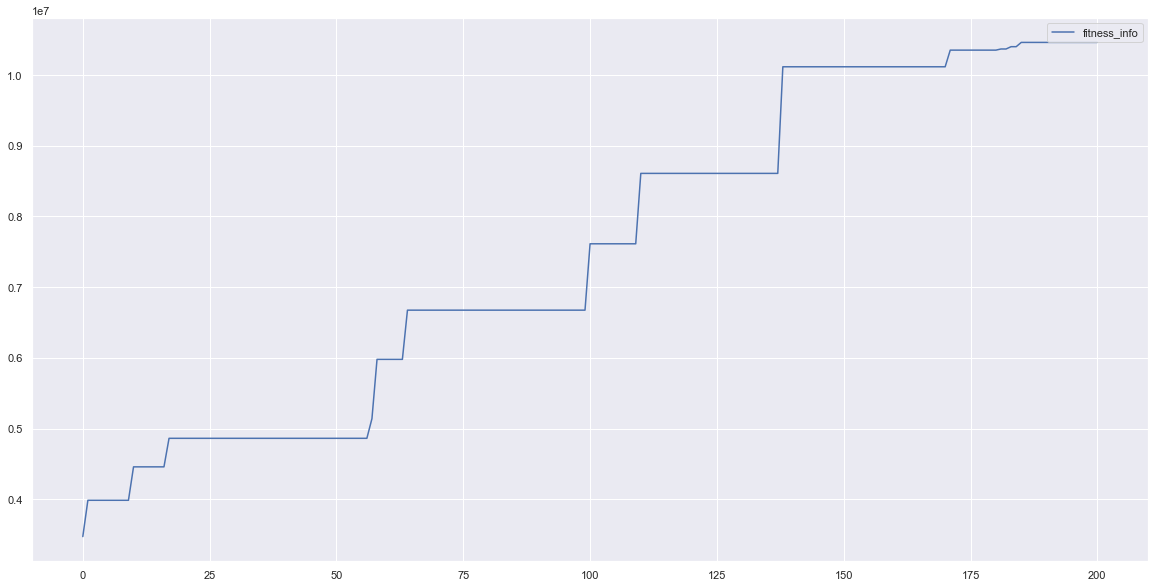

In [30]:
sns.lineplot(data=info_dict)
sns.set(rc={'figure.figsize':(30,10)})

# ===============TEST================

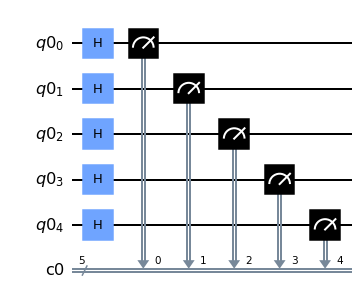

In [1]:
from qiskit import *
%matplotlib inline
# just do this once - save your token to your computer to use later (IBMQ.load_account()
# get the token from your account in https://quantum-computing.ibm.com/
#  MyAccount -> Qiskit in local environment -> Copy Token
# IBMQ.save_account('your token here....’)
### A. Build The Quantum Circuit
qr = QuantumRegister(5) # quantum bit register
cr = ClassicalRegister(5) # classical bit register
circuit = QuantumCircuit(qr, cr)
# create a quantum circuit containing 5 qubits
# all qubits in superposition (50%:50% chance to be in |0> or |1>) and independent of each other
circuit.h(qr)
circuit.measure(qr, cr)
circuit.draw(output='mpl', scale=1)

In [7]:
### B2. Execute the Quantum Circuit in real Quantum Computer on IBM Quantum Computing Experience
# Run our quantum circuit on The "Quantum Computer on IBM Cloud" by submitting a job containing our defined quantum circuit
from qiskit.tools.monitor import job_monitor
# load saved credential to access IBM Quantum Computing Experience on IBM Cloud
IBMQ.load_account()
# define the backend IBM quantum computer simulator to use
qprovider = IBMQ.get_provider('ibm-q')
backends = qprovider.backends()
backends

ibmqfactory.load_account:WARNING:2021-04-13 07:31:43,079: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [9]:
### B2. Execute the Quantum Circuit in real Quantum Computer on IBM Quantum Computing Experience
# Run our quantum circuit on The "Quantum Computer on IBM Cloud" by submitting a job containing our defined quantum circuit
from qiskit.tools.monitor import job_monitor
# load saved credential to access IBM Quantum Computing Experience on IBM Cloud
IBMQ.load_account()
# define the backend IBM quantum computer simulator to use
qprovider = IBMQ.get_provider('ibm-q')
qbackend = qprovider.get_backend('ibmqx2')
job = execute(circuit, backend=qbackend, shots=8192, memory=True)
job_monitor(job)

ibmqfactory.load_account:WARNING:2021-04-13 07:32:30,036: Credentials are already in use. The existing account in the session will be replaced.
Job Status: job has successfully run


In [10]:
rawvalues_ibmq = job.result().get_memory()
print(rawvalues_ibmq)

['01111', '10110', '10010', '01011', '10101', '01010', '01010', '00110', '00010', '11110', '10101', '00001', '11111', '11111', '01100', '10001', '01001', '10100', '00011', '10100', '10000', '10110', '01111', '01010', '10111', '10001', '10111', '00000', '00010', '01100', '11101', '01011', '10001', '10000', '01110', '01111', '10011', '10000', '00111', '00010', '00011', '01100', '10100', '01010', '01100', '11001', '01010', '00011', '01001', '11101', '01000', '10101', '00110', '10001', '11101', '00011', '01110', '10001', '01001', '00000', '01101', '00101', '00100', '10110', '10011', '10010', '11000', '01110', '10000', '01110', '10101', '01110', '00011', '00010', '11011', '01010', '10011', '00111', '11101', '11110', '10000', '11101', '01111', '11110', '10110', '00100', '10000', '01011', '01001', '00000', '10100', '01101', '00011', '10000', '11010', '01010', '00110', '01000', '00101', '00000', '00011', '10100', '10001', '10111', '01100', '10110', '01100', '00111', '01001', '10011', '00000', 

In [11]:
result = job.result()
counts = result.get_counts()
print(counts)

{'00000': 288, '00001': 244, '10000': 249, '10001': 227, '10010': 242, '10011': 251, '10100': 298, '10101': 237, '10110': 305, '10111': 300, '11000': 204, '11001': 171, '11010': 208, '11011': 214, '11100': 239, '11101': 209, '11110': 248, '11111': 222, '00010': 293, '00011': 267, '00100': 366, '00101': 292, '00110': 326, '00111': 320, '01000': 226, '01001': 214, '01010': 238, '01011': 238, '01100': 296, '01101': 234, '01110': 273, '01111': 253}
